In [1]:
# Necessary libraries
import numpy as np
import math
import matplotlib.pyplot as plt

In [2]:
eps = np.finfo(float).eps # Machine precision
plt.rcParams['figure.dpi'] = 120 # Plot size

Markdown macros:
$$
\newcommand{\abs}[1]{\left| #1 \right|}
\newcommand{\fun}[2]{#1 \! \left( #2 \right)}
$$

# (a)

In the problem statement, the truncated series is defined as
\begin{align*}
\fun{S_{n}}{x}
&:=
\sum_{k=0}^{n} \frac{x^{k}}{k!},
\end{align*}
which actually contains $n+1$ terms. So I interpret the instructions to mean that the input $n$ is the desired truncation order, not the number of terms.

In [3]:
# The straightforward series approximation
def exp_series(x:float, n:int, rtol:float = eps/2) -> float:
    """
    Maclaurin series for exp(x) with maximum order n.

    Inputs:
        x : The point at which to evaluate the series.
        n : The truncation order of the series.
        rtol : The relative tolerance; the sum stops if the next term is a fraction rtol of the sum so far.

    Output:
        total : The result of the summation.
    """

    # Enforce n >= 0
    if n < 0:
        raise ValueError("n must be >= 0.")

    total = 1.0
    term = 1.0
    for k in range(1,n+1):
        term *= x / k # Avoid computing factorials

        # Stop if next term is tiny compared to sum
        if abs(term) <= rtol * abs(total):
            return total
            
        total += term
    return total

In [4]:
# Alternatively, a Horner series is probably better, but not in the spirit of the problem
def exp_series_horner(x:float, n:int) -> float:
    total = 1.0
    for k in range(n, 0, -1):
        total = 1.0 + (x * total) / k
    return total

# (b)

$\exp(x) > 0$ for all $x \in \mathbb{R}$, so the standard formula for relative error reduces to
\begin{align*}
\epsilon_{n}
&:=
\frac{\abs{\exp(x) - \fun{S_{n}}{x}}}{\abs{\exp(x)}}
=
\frac{\abs{\exp(x) - \fun{S_{n}}{x}}}{\exp(x)}.
\end{align*}

In [5]:
def rel_errors(x:float, n_min:int = 0, n_max:int = 100):
    """
    Array of relative errors in truncated Maclaurin series of exp(x).

    Inputs:
        x : The point at which to evaluate the error.
        n_min : The lowest desired truncation order.
        n_max : The largest desired truncation order.

    Outputs:
        ns : Array of truncation orders between n_min and n_max, inclusive.
        errors : Array of relative errors.
    """
    if not(0 <= n_min <= n_max):
        raise ValueError("Need 0 <= n_min <= n_max.")
    exp_true = math.exp(x) # Pre-compute this
    ns = np.arange(n_min, n_max+1, dtype=int)
    errors = np.array([abs(exp_true - exp_series(x, n)) / exp_true for n in ns])
    return ns, errors

In [6]:
ns_pos, errors_pos = rel_errors(20, 0, 100)
ns_neg, errors_neg = rel_errors(-20, 0, 100)

For a log-log plot, we need to drop the $n = 0$ term and make sure every error is non-negative, or at least greater than machine precision.

In [7]:
# Remove everything <= 0 for the log-log plot
mask = ns_pos > 0
ns_plot = ns_pos[mask]
errors_pos_plot = np.maximum(errors_pos[mask], eps)
errors_neg_plot = np.maximum(errors_neg[mask], eps)

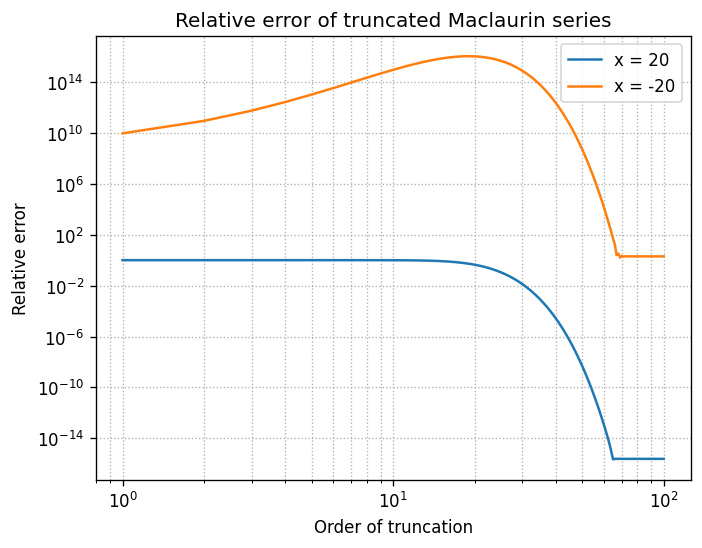

In [8]:
plt.loglog(ns_plot, errors_pos_plot, label='x = 20')
plt.loglog(ns_plot, errors_neg_plot, label='x = -20')
plt.xlabel('Order of truncation')
plt.ylabel('Relative error')
plt.title('Relative error of truncated Maclaurin series')
plt.grid(True, which='both', ls=':')
plt.legend()
plt.show()

The behavior for $x = -20$ is due to catastrophic cancellation. The series approximation wildly oscillates:

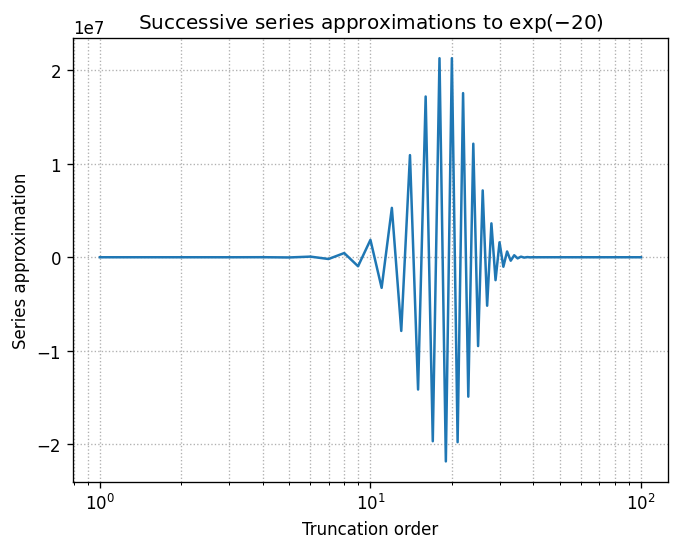

In [9]:
ns = np.arange(1, 101, dtype=int)
truncations = np.array([exp_series(-20, n) for n in ns])
plt.semilogx(ns, truncations)
plt.xlabel('Truncation order')
plt.ylabel('Series approximation')
plt.title(r'Successive series approximations to $\exp(-20)$')
plt.grid(True, which='both', ls=':')
plt.show()

Meanwhile, the true value is $\exp(-20) \approx 2 \times 10^{-9}$. Therefore, roundoff removes most digits and the relative error approaches $1$. The reason why the error peaks near $n = 20$ is because $\abs{x^{k} / k!}$ peaks at $k \approx x - 1/2$.

# (c)

We can fix this problem by computing $\fun{S_{n}}{x}$ for $x < 0$ as $1 / \fun{S_{n}}{-x}$. Suppose $\fun{S_{n}}{x}$ has relative error $\delta$ when $x > 0$:
\begin{align*}
\fun{S_{n}}{x}
&=
\exp(x) \left(1 + \delta\right),
\end{align*}
where $\abs{\delta} \ll 1$.
Then
\begin{align*}
\frac{1}{\fun{S_{n}}{x}}
&=
\exp(-x) \left(1 - \delta + \delta^{2} - \cdots\right)
\\
&\approx
\exp(-x) \left(1 - \delta\right).
\end{align*}
Therefore computing $\exp(x)$ for $x < 0$ by taking the reciprocal of $\fun{S_{n}}{-x}$ also has small relative error $\sim \abs{\delta}$. The plot confirms that this method produces a smaller relative error than the naïve method.

In [10]:
def exp_series_better(x:float, n:float, rtol=eps) -> float:
    """
    Maclaurin series for exp(x) with maximum order n.
    Negative cases are handled by the reciprocal.
    """
    if x >= 0.0:
        return exp_series(x, n, rtol)
    return 1.0/exp_series(-x, n, rtol)

In [11]:
def rel_errors_better(x, n_max = 100):
    """Array of errors in improved truncated Maclaurin series of exp(x)"""
    exp_true = math.exp(x) # Pre-compute this
    ns = np.arange(0, n_max+1, dtype=int)
    errors = np.array([abs(exp_true - exp_series_better(x, n)) / exp_true for n in ns])
    return ns, errors

In [12]:
ns_pos_better, errors_pos_better = rel_errors_better(20, 100)
ns_neg_better, errors_neg_better = rel_errors_better(-20, 100)

In [13]:
# Remove everything <= 0 for the log-log plot
mask = ns_pos_better > 0
ns_better_plot = ns_pos_better[mask]
errors_pos_better_plot = np.maximum(errors_pos_better[mask], eps)
errors_neg_better_plot = np.maximum(errors_neg_better[mask], eps)

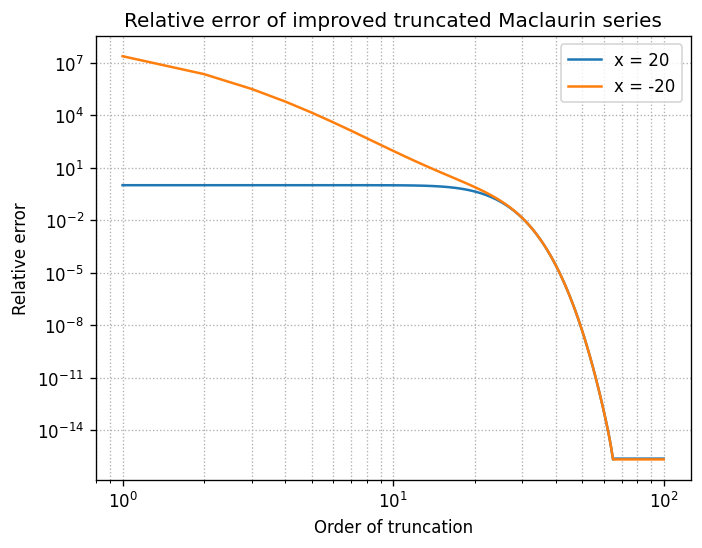

In [14]:
plt.loglog(ns_better_plot, errors_pos_better_plot, label='x = 20')
plt.loglog(ns_better_plot, errors_neg_better_plot, label='x = -20')
plt.xlabel('Order of truncation')
plt.ylabel('Relative error')
plt.title('Relative error of improved truncated Maclaurin series')
plt.grid(True, which='both', ls=':')
plt.legend()
plt.show()